# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.

### Установка зависимостей

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
print(PIL.__version__)

9.4.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [5]:
!ls train

simpsons_dataset


In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Nov 12 15:11:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [7]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import torchvision.models as models
from torchvision import transforms

from multiprocessing.pool import ThreadPool

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

from matplotlib import colors, pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

import seaborn as sns

import pandas as pd

%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [8]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # Список файлов для загрузки
        self.files = sorted(files)
        # Режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # Для преобразования изображений в тензоры PyTorch и нормализации входа
        # Используем аугментацию данных
        transform = transforms.Compose([

            # Преобразуем изображение в тензор PyTorch
            transforms.ToTensor(),
            # Случайный поворот на угол от -10 до 10 градусов
            transforms.RandomRotation(degrees=(-10, 10)),
            # Случайное горизонтальное отражение изображения
            transforms.RandomHorizontalFlip(),
            # Нормализация изображения
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Функция для визуализации распределения данных по классам будет иметь следующий вид

In [54]:
def get_plot_stat(dataset, title):

  # Получение label из датасета
  if type(dataset) == list:
    labels = [path.parent.name for path in dataset]
  if type(dataset) == np.ndarray:
    labels = [path for path in dataset]
  else:
    labels = [dataset.label_encoder.classes_[label] for _, label in dataset]

  counts = pd.Series(labels).value_counts()
  counts_df = pd.DataFrame({'Characters': counts.index, 'Count': counts.values})

  # Настройка стиля Seaborn
  sns.set(style="whitegrid")

  # Создание графика распределения с использованием Seaborn
  plt.figure(figsize=(10, 8))
  sns.barplot(x='Count', y='Characters', data=counts_df.sort_values(by='Count', ascending=True), palette="viridis")
  plt.title(title)
  plt.xlabel('Count')
  plt.ylabel('Characters')
  plt.show()

In [16]:
# Определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [17]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Визуализируем распределение данных по классам

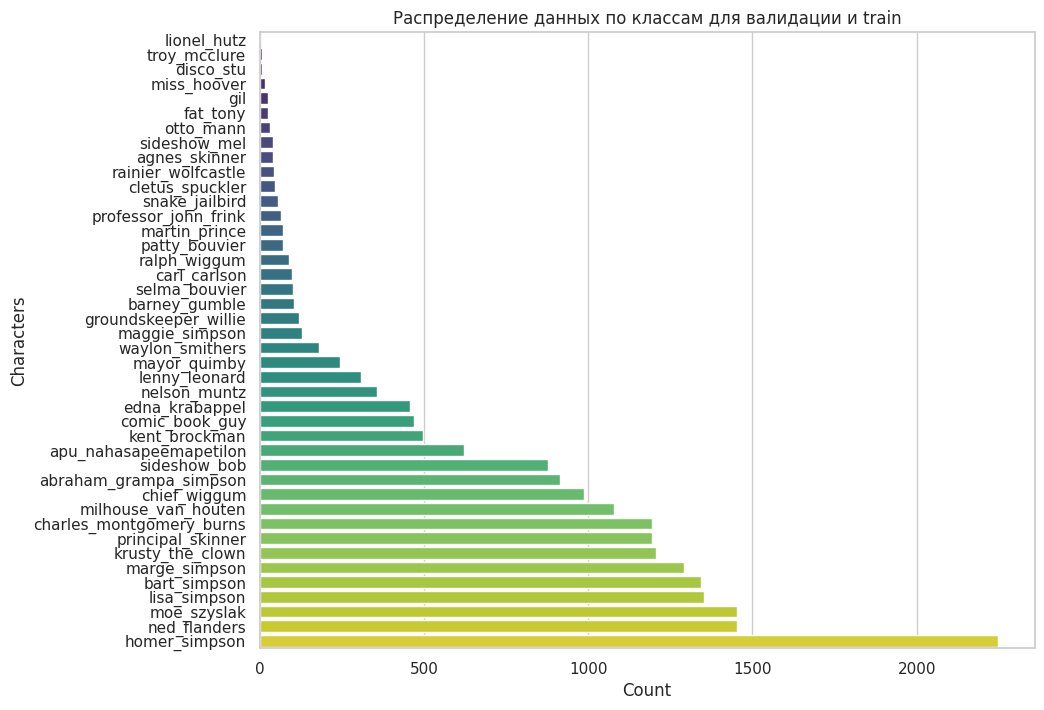

In [27]:
get_plot_stat(train_val_files, 'Распределение данных по классам для валидации и train')

В данных присутствует дисбаланс классов, будем делать аугментацию

Разделим тренировочные данные на train и validation в соотношении 3 : 1

In [20]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [21]:
# Создадим валидационный датасет
val_dataset = SimpsonsDataset(val_files, mode='val')

Визуализируем распределение классов для валидационного датасета

In [25]:
print(type(val_dataset))

<class '__main__.SimpsonsDataset'>


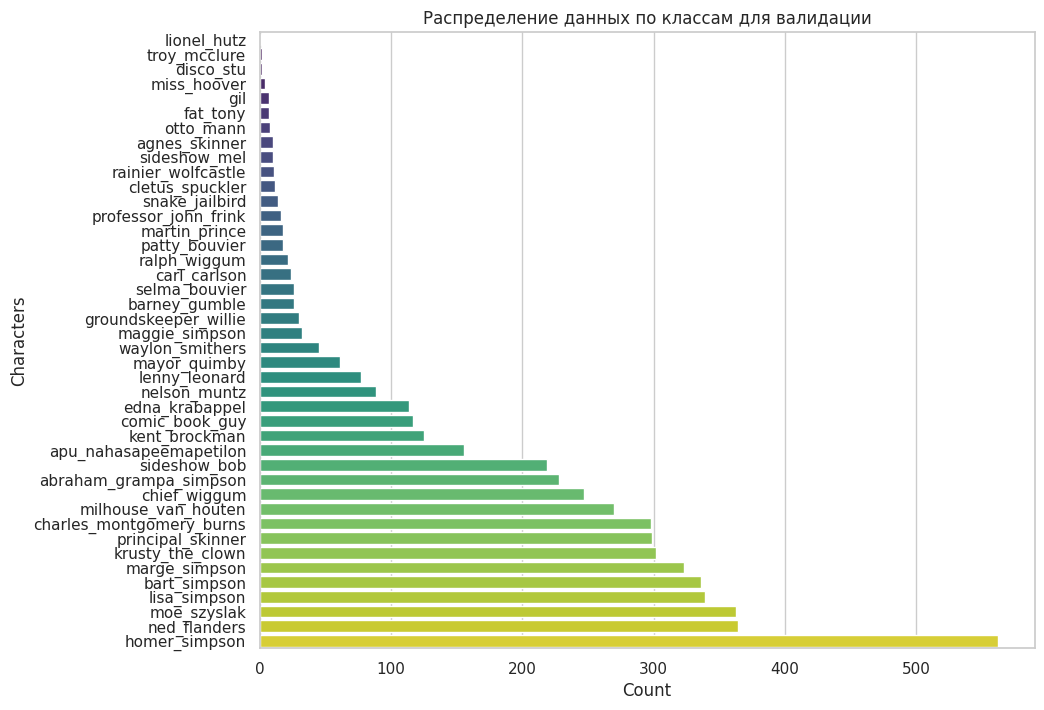

In [28]:
get_plot_stat(val_dataset, 'Распределение данных по классам для валидации')

Давайте посмотрим на наших героев внутри датасета.

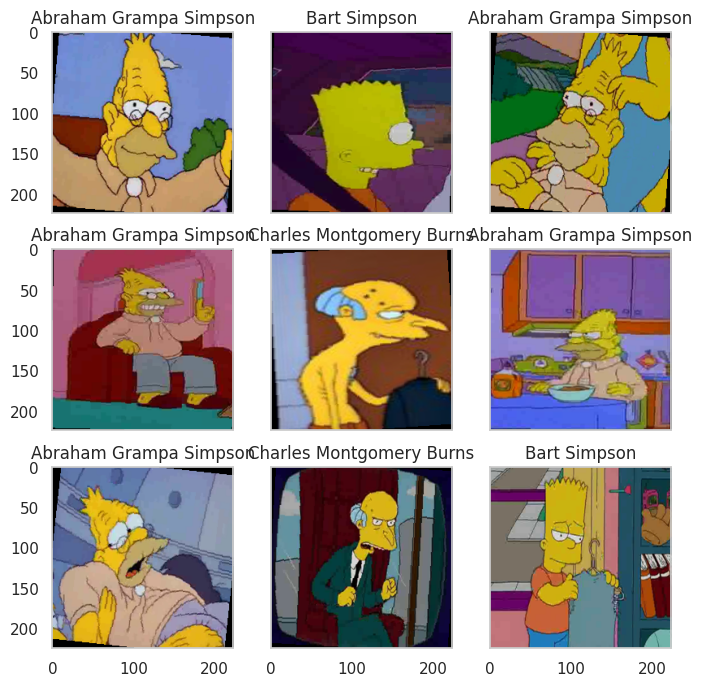

In [29]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Определим функцию предсказания на тестовой выборке

In [30]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [31]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

# Создадим тренировочный датасет
train_dataset = SimpsonsDataset(train_files, mode='train')

Визуализируем распределение классов для train датасета

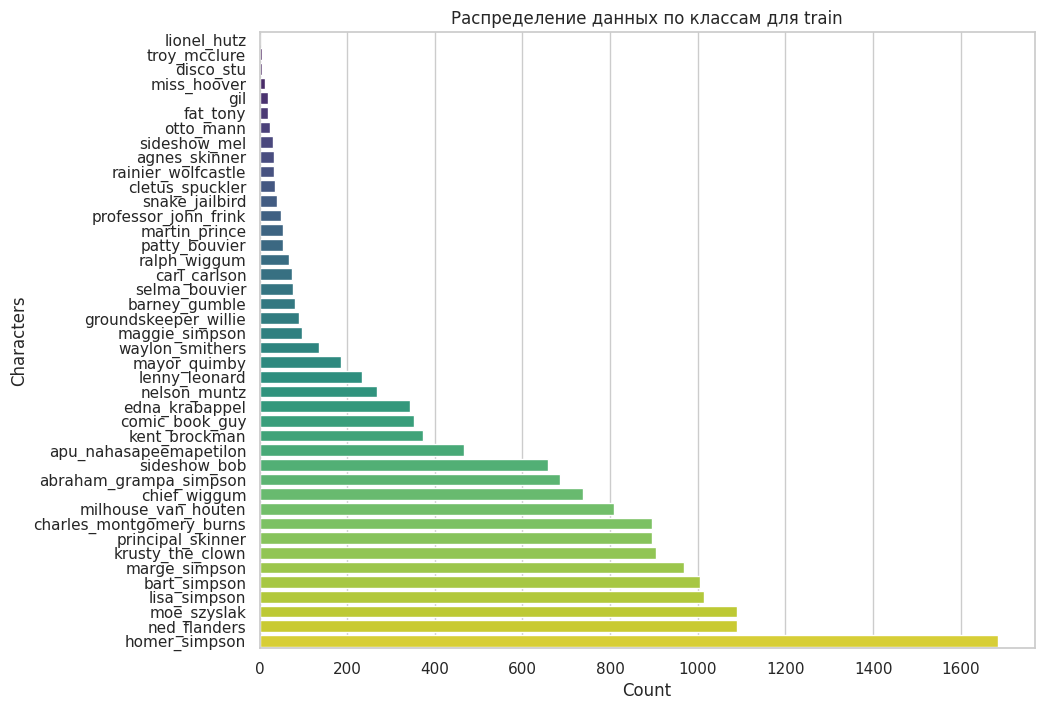

In [32]:
get_plot_stat(train_dataset, 'Распределение данных по классам для train')

Определим функцию fine tune для дообучения модели ResNet50 на нашем датасете

In [33]:
def fine_tune_resnet50(model, train_loader, val_loader, criterion, optimizer, scheduler, batch_size, num_epochs=5):

    # Создаем DataLoader для обучающего набора данных с перемешиванием
    train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)
    # Создаем DataLoader для валидационного набора данных, но без перемешивания
    val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False)

    # Определяем устройство (GPU или CPU) для выполнения вычислений
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Переносим модель на определенное устройство (GPU или CPU)
    model.to(device)

    # Создаем словарь для отслеживания значений потерь и точности на обучающем и валидационном наборах данных
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    # Начинаем цикл обучения по заданному числу эпох
    for epoch in range(num_epochs):

        # Установление модели в режим обучения
        model.train()

        # Обнуляем переменные
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Переносим входные данные и метки на устройство (GPU или CPU)
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Обнуляем градиенты перед обратным распространением
            optimizer.zero_grad()

            # Получаем прогнозы модели для входных данных
            outputs = model(inputs)
            # Вычисляем потери между прогнозами и истинными метками
            loss = criterion(outputs, labels)
            # Выполняем обратное распространение для вычисления градиентов
            loss.backward()
            # Обновляем веса модели на основе градиентов
            optimizer.step()

            # Накапливаем потери на текущем батче
            running_loss += loss.item()

            # Находим индексы максимальных значений в выходах модели
            _, predicted = outputs.max(1)
            # Увеличиваем общее количество обучающих образцов на размер текущего батча
            total_train += labels.size(0)
            # Увеличиваем количество правильно предсказанных образцов за текущий батч
            correct_train += predicted.eq(labels).sum().item()

        # Вычисляем средние потери за эпоху
        epoch_loss = running_loss / len(train_loader)
        # Вычисляем среднюю точность за эпоху
        epoch_accuracy = correct_train / total_train

        # Добавляем значение средних потерь за эпоху в историю обучения
        history['train_loss'].append(epoch_loss)
        # Добавляем значение средней точности за эпоху в историю обучения
        history['train_accuracy'].append(epoch_accuracy)

        # Выводим информацию о средних потерях и точности для текущей эпохи
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}")

        # Обновление learning rate с использованием планировщика
        scheduler.step()

        # Валидация на каждой эпохе (если есть валидационный DataLoader)
        if val_loader is not None:
            # Установление модели в режим оценки (валидации)
            model.eval()

            # Обнуляем переменные
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0

            # Блок кода, в котором градиенты вычисляться не будут
            with torch.no_grad():
                # Этот цикл проходит через валидационный DataLoader, который предоставляет входные данные и соответствующие метки
                for inputs_val, labels_val in val_loader:
                    # Переносим входные данные и метки на устройство (GPU или CPU), в зависимости от доступности GPU
                    inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

                    # Получаем выходы (предсказания) модели для валидационных данных
                    outputs_val = model(inputs_val)
                    # Вычисляем потери между предсказаниями и истинными метками
                    val_loss = criterion(outputs_val, labels_val)

                    # Накапливаем общие потери на протяжении всей валидации
                    running_val_loss += val_loss.item()

                    # Вычисляем индексы классов с максимальной вероятностью (предсказанные классы)
                    _, predicted_val = outputs_val.max(1)
                    # Увеличиваем общее количество валидационных образцов
                    total_val += labels_val.size(0)
                    # Увеличиваем количество правильных предсказаний, сравнивая предсказанные классы с истинными метками
                    correct_val += predicted_val.eq(labels_val).sum().item()

            # Вычисляем средние потери на валидационном наборе данных
            epoch_val_loss = running_val_loss / len(val_loader)
            # Вычисляем точность на валидационном наборе данных
            epoch_val_accuracy = correct_val / total_val

            # Добавляем средние потери в историю валидационных потерь для последующего анализа
            history['val_loss'].append(epoch_val_loss)
            # Добавляем точность в историю валидационной точности для последующего анализа
            history['val_accuracy'].append(epoch_val_accuracy)

            # Выводим информацию о потерях и точности на валидационном наборе данных после каждой эпохи обучения
            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}")

    # Выводим сообщение о завершении обучения
    print("Training complete")

    # Возвращаем словарь с историей значений потерь и точности для обучающего и валидационного наборов данных
    return history

Импортируем ResNet50

In [34]:
# Загружаем предварительно обученную модель ResNet-50 из библиотеки torchvision
resnet50 = models.resnet50(pretrained=True)

# Определяем количество классов для последнего fully connected слоя
num_classes = 42
# Меняем последний fully connected слой модели для адаптации к новому количеству классов
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# Задаем размер входных данных (трехканальные изображения размером 224x224)
input_size = (3, 224, 224)
# Создаем фиктивные входные данные для определения архитектуры модели
dummy_input = torch.randn(1, *input_size)
# Меняем первый сверточный слой (conv1) модели для адаптации к новому размеру входных данных
resnet50.conv1 = nn.Conv2d(input_size[0], 64, kernel_size=7, stride=2, padding=3, bias=False)

# Размораживаем все параметры модели для обучения
for param in resnet50.parameters():
    param.requires_grad = True

# Определяем устройство (GPU, если доступен, в противном случае - CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Переносим модель на указанное устройство
resnet50.to(device)

# Переносим фиктивные входные данные на указанное устройство
dummy_input = torch.randn(1, *input_size).to(device)

# Определяем функцию потерь (кросс-энтропия) для обучения с учителем
criterion = nn.CrossEntropyLoss()
# Определяем оптимизатор Adam с заданным коэффициентом обучения.
optimizer = optim.Adam(resnet50.parameters(), lr=3e-4)

# Определяем планировщик шагового уменьшения learning rate с периодом 7 эпох и уменьшением на 0.1
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


Краткий обзора архитектуры модели ResNet50

In [35]:
from torchsummary import summary
summary(resnet50, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Дообучим ResNet50 на наших данных, сохраним точность и потери для train и валидации

In [36]:
# Устанавливаем размер батча
batch_size = 128
# Определим количество эпох обучения
num_epochs = 30

# Дообучим ResNet50 на наших данных
history = fine_tune_resnet50(resnet50, train_dataset, val_dataset, criterion, optimizer, scheduler, batch_size=batch_size, num_epochs=num_epochs)

Epoch 1/30, Train Loss: 0.8867236065670727, Train Accuracy: 0.7881393719345181
Epoch 1/30, Validation Loss: 0.5104849525704617, Validation Accuracy: 0.8758119984715322
Epoch 2/30, Train Loss: 0.2999213747377318, Train Accuracy: 0.9219695522007771
Epoch 2/30, Validation Loss: 0.35280133438546485, Validation Accuracy: 0.9098204050439435
Epoch 3/30, Train Loss: 0.19493701890474413, Train Accuracy: 0.9484680552901459
Epoch 3/30, Validation Loss: 0.27406101301312447, Validation Accuracy: 0.9300726022162782
Epoch 4/30, Train Loss: 0.1395755932340777, Train Accuracy: 0.9647111280973311
Epoch 4/30, Validation Loss: 0.3188644109248388, Validation Accuracy: 0.9189912113106611
Epoch 5/30, Train Loss: 0.10164084025030214, Train Accuracy: 0.972163832091216
Epoch 5/30, Validation Loss: 0.2644407493175893, Validation Accuracy: 0.9340848299579672
Epoch 6/30, Train Loss: 0.09395248548892456, Train Accuracy: 0.9742658768074399
Epoch 6/30, Validation Loss: 0.23979063254849212, Validation Accuracy: 0.9382

Сохраним точности и потери в отдельные переменные

In [37]:
# Потери для train
loss = history['train_loss']
# Точность для train
acc = history['train_accuracy']
# Потери для валидации
val_loss = history['val_loss']
# Точность для валидации
val_acc = history['val_accuracy']

Построим графики потерь и точность для train и валидации в зависимости от эпох обучения

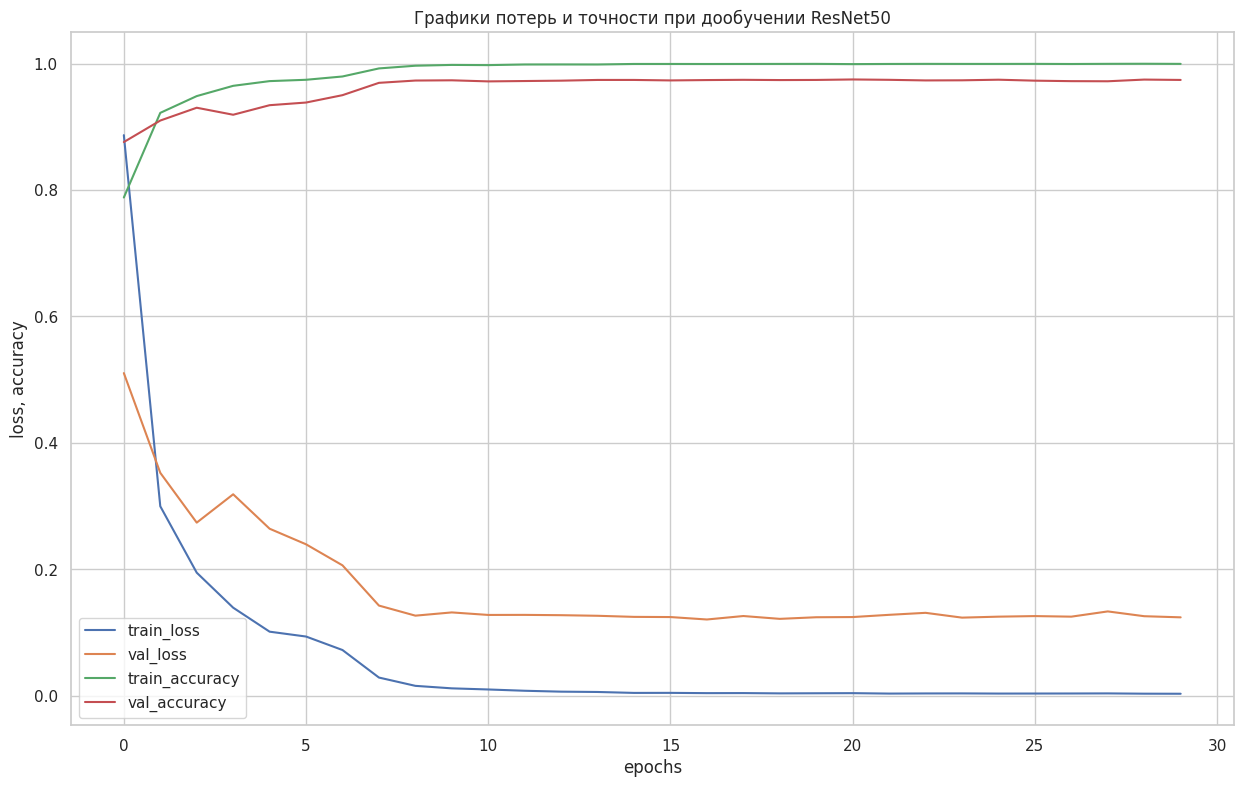

In [38]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.plot(acc, label="train_accuracy")
plt.plot(val_acc, label="val_accuracy")
plt.title('Графики потерь и точности при дообучении ResNet50')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss, accuracy")
plt.show()

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [39]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [57]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet50, ex_img.unsqueeze(0))

In [58]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet50, imgs)

In [59]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [60]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [61]:
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 1.0


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

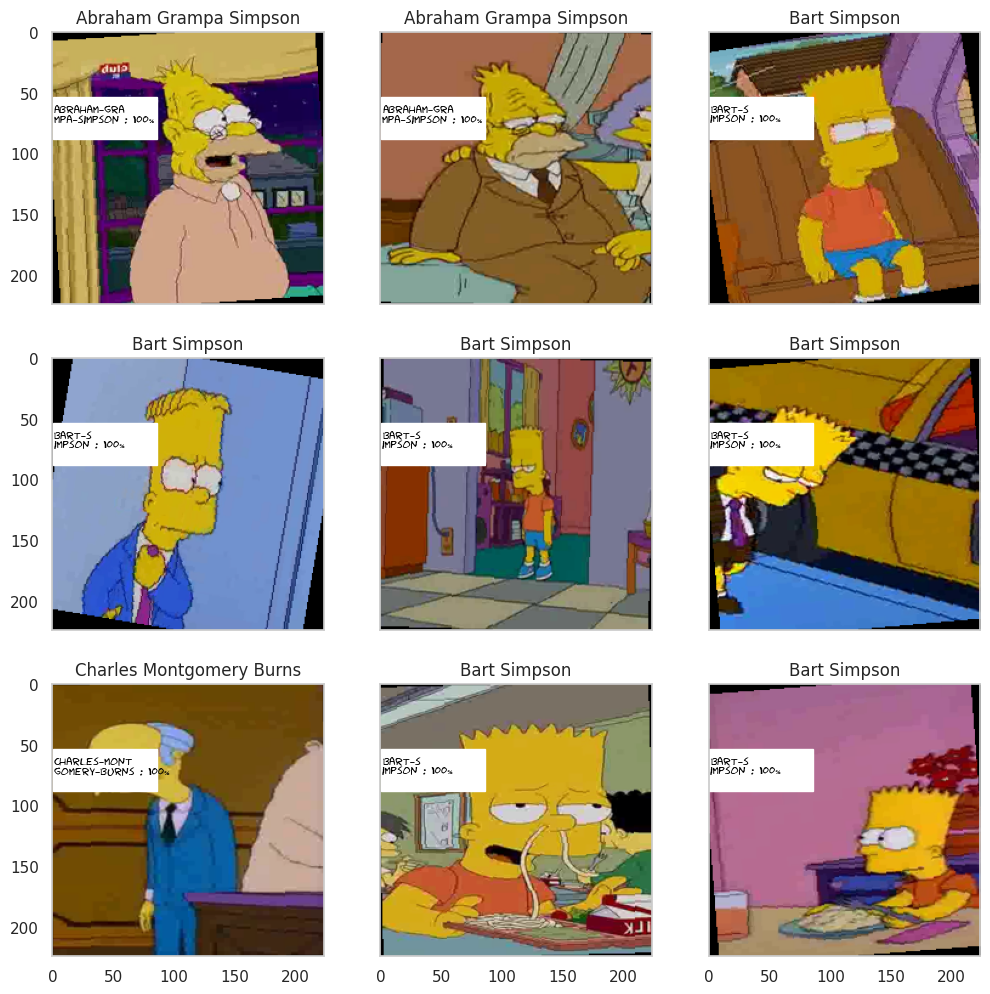

In [62]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet50, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [63]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(resnet50, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

Визуализируем предсказание для теста

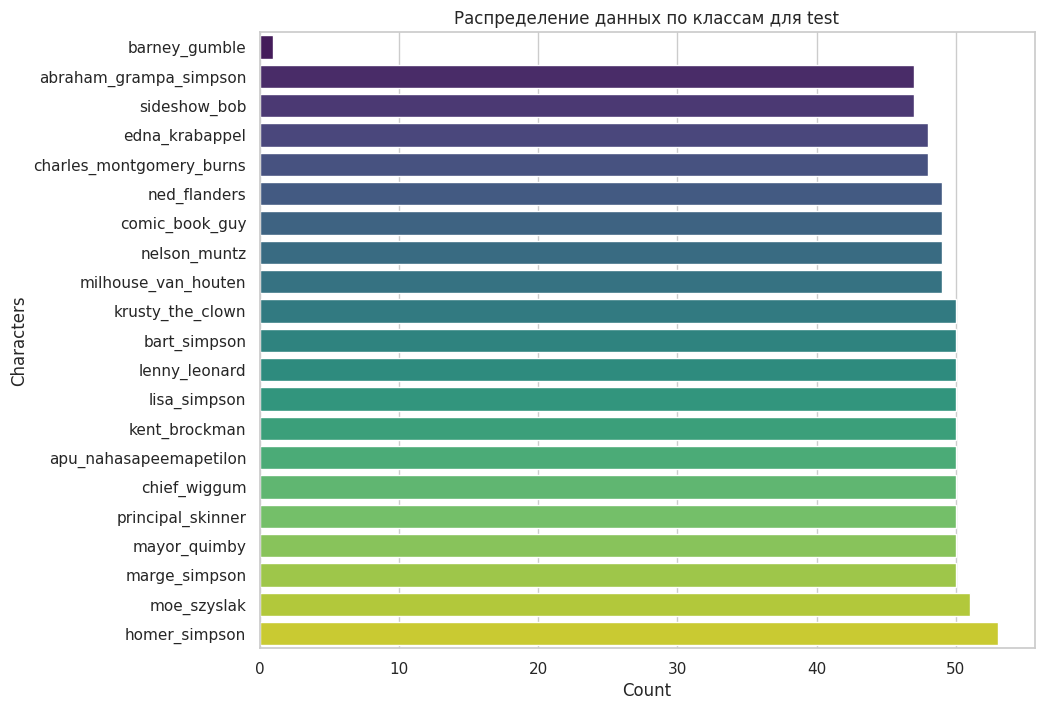

In [64]:
get_plot_stat(preds, 'Распределение данных по классам для test')

In [65]:
! ls

characters_illustration.png  resnet50_cnn_baseline.csv	simple_cnn_baseline.csv
gdrive			     sample_data		testset
label_encoder.pkl	     sample_submission.csv	train


In [68]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [69]:
my_submit.to_csv('resnet50_cnn_baseline.csv', index=False)

**Итог: метрика F1 score на публичной части датасета соревнования на kaggle 0.99574**
Алексей_Старухин_583272981, 524 место

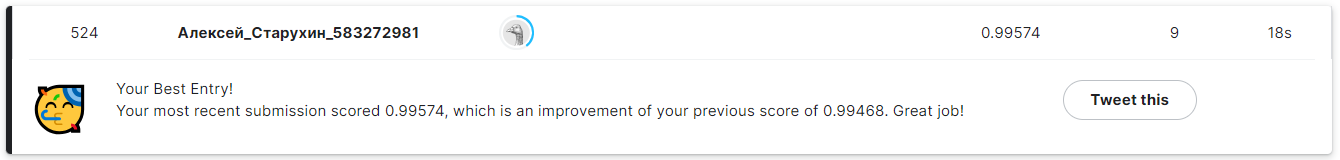

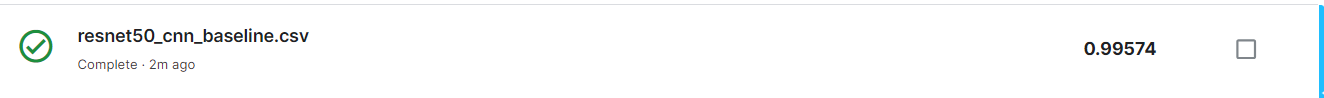